In [1]:
import sys
sys.path.insert(0, '..')
%load_ext autoreload
%autoreload 2
%aimport std_func

# Hide warnings
import warnings
warnings.filterwarnings("ignore")

## Estimates from Factor Model
We assume a factor model where there are $k$ assets and $T$ time periods (months in our case), m is the common factors (topic weights in our case). $r_{it}$ is the return for asset $i$ at time $t$.

$$
\begin{align}
r_{it}
= &\alpha_i + \sum_{j=1}^{m} \beta_{ij} f_jt + \epsilon_{it}, t = 1, \dots, T, i = 1, \dots, k\\ \\
R_{k \times T} = & B_{k \times m} \cdot coef_{m \times T} + E_{k \times T}
\end{align}
$$

In our analysis, $R_{k \times T}$ is the returns matrix imported, $B_{k \times m}$ is the topic modeling matrix, and $coef_{m \times T}$ is the coefficient matrix computed from the linear regression of returns matrix on topic modeling matrix. $E_{k \times T}$ is the residual matrix.

In our factor model, 

$$\text{Cov}(r) = B \Sigma_{coef} B^T + D, 
\text{ where } D = diag(\sigma^2_1, \dots, \sigma^2_k) \text{ and Var}(\epsilon_i) = \sigma^2_i$$

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import json
import string
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [91]:
r_selected = pd.read_csv("data/filtered_r.csv")
# get the mean of all 
r_selected.set_index("name", inplace = True)
mu = r_selected.mean(axis = 1)
# compute the covariance matrix 
cov = r_selected.T.cov()

In [4]:
df = pd.read_csv('../data/preprocessed.csv',
                 usecols = ['reportingDate', 'name', 'CIK', 'coDescription',
                           'coDescription_stopwords', 'SIC', 'SIC_desc'])
df = df.set_index(df.name)

### Sent-LDA
We ran the coherence score benchmarking over a range of 3 to 40 topics, incrementing by 3. 

First, we fit the LDA model to all business description using the number of topics selected from coherence score benchmarking. 

Then, we assume each sentence only represents one topic; get the frequency of the topics revealed in the whole document (business description for one company) and calculate the probability of each topics in the whole document. 

#### Coherence Score Plot

![Factor_Model_Coherence_Score.png](images/Factor_Model_Coherence_Score.png)

Based on the above Coherence Score, we choose up to 12 topics since it gives the highest score up to here.

In [5]:
data = df.loc[:,"coDescription_stopwords"].to_list()

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_df=0.85, min_df=2, max_features=600)
tf = tf_vectorizer.fit_transform(data)
tf_feature_names = tf_vectorizer.get_feature_names_out()
lda = LatentDirichletAllocation(n_components=12, random_state=0).fit(tf)

We show the top 10 words by weights in the 12 topics LDA model generates in the below table.

In [7]:
std_func.get_topics(lda, tf_vectorizer, 12)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10,Topic # 11,Topic # 12
0,could,loan,share,product,investment,gas,hotel,patient,bank,customer,million,cell
1,gas,mortgage,stock,drug,income,oil,facility,treatment,capital,service,tax,cancer
2,regulation,real,note,fda,asset,natural,tenant,trial,institution,data,asset,tumor
3,oil,estate,issued,clinical,reit,production,lease,study,federal,product,net,product
4,future,commercial,preferred,patent,real,reserve,operating,phase,act,solution,income,therapy
5,natural,bank,date,approval,tax,proved,estate,clinical,banking,software,cash,therapeutic
6,price,interest,amount,trial,share,drilling,million,disease,holding,platform,expense,clinical
7,affect,rate,september,application,interest,regulation,real,drug,regulation,technology,value,technology
8,ability,million,per,regulatory,distribution,net,center,therapy,deposit,application,note,research
9,adversely,security,director,candidate,estate,water,portfolio,data,asset,sale,statement,license


#### Frequency of the Topics in Each Sentence

In [8]:
n_components = 12
prob = pd.DataFrame(0, index = df.name, columns = range(n_components))

In [9]:
for j in range(len(df)):
    LIST_sent = pd.Series(df.coDescription[j].split('.')).apply(std_func.lemmatize_sentence).apply(std_func.remove_nums).apply(std_func.remove_stopwords)
    
    X = tf_vectorizer.transform(LIST_sent.tolist())
    sent = lda.transform(X)
    sent_df = pd.DataFrame(sent)
    # drop the values that are smaller than 1/12
    # if the maximum value is 1/12, the probability of each topic in that sentence is the same
    # we cannot determine which topic to choose
    sent_df = sent_df[sent_df.max(axis = 1) > 1/12].reset_index(drop = True)

    for i in range(n_components):
        prob.iloc[j][i] = list(sent_df.idxmax(axis = 1)).count(i)
    
    # calculate the probability
    prob = prob.div(prob.sum(axis=1), axis=0)

In [10]:
prob

,0,1,2,3,4,5,6,7,8,9,10,11
name,,,,,,,,,,,,
"MONGODB, INC.",0.014652,0.007326,0.021978,0.036630,0.018315,0.010989,0.040293,0.021978,0.014652,0.739927,0.047619,0.025641
SALESFORCE COM INC,0.010811,0.010811,0.005405,0.016216,0.000000,0.021622,0.037838,0.005405,0.005405,0.821622,0.054054,0.010811
SPLUNK INC,0.010274,0.003425,0.013699,0.020548,0.013699,0.003425,0.023973,0.000000,0.003425,0.839041,0.058219,0.010274
"OKTA, INC.",0.020305,0.000000,0.015228,0.050761,0.015228,0.005076,0.040609,0.000000,0.015228,0.786802,0.030457,0.020305
VEEVA SYSTEMS INC,0.093245,0.012845,0.094196,0.028544,0.035205,0.008563,0.019981,0.010466,0.017602,0.315414,0.352046,0.011893
...,...,...,...,...,...,...,...,...,...,...,...,...
"AMERICAN REALTY CAPITAL NEW YORK CITY REIT, INC.",0.075472,0.084906,0.122642,0.009434,0.471698,0.009434,0.075472,0.000000,0.000000,0.066038,0.084906,0.000000
"CYCLACEL PHARMACEUTICALS, INC.",0.027460,0.000000,0.029748,0.272311,0.011442,0.009153,0.018307,0.308924,0.000000,0.029748,0.013730,0.279176
ZOETIS INC.,0.036519,0.018868,0.074254,0.033475,0.034084,0.013999,0.035301,0.018868,0.020694,0.053561,0.644553,0.015825


### Factor Modelling
The common factors in our factor model are the 12 topics selected from LDA model. We use the calculated probability matrix of each topic for each companies as the topic modelling matrix $B$. Then a linear regression of returns matrix on topic modelling matrix will give us the coefficient matrix for the 12 factors. 

At each time $t$, we run a linear regression of $r_t$ on the topic modelling matrix (common factor matrix) $B$ to generate a coefficient vector for time $t$. At the same time, a residual vector $\epsilon_t$ can be calculated using the diffrence of the actual $r_t$ along with the predicted value $\hat r_t$.

After $T$ times (31 months in our case) of linear regression, we have a coefficient matrix $coef_{T\times m}$ with 12 topics as columns and 31 months as rows as well as a residual matrix with 31 months as columns and the number of companies as rows. We will construct the diagonal matrix $D$ using the diagonal values of covariance of the resiudal matrix which are the variance of residuals $\text{Var}(\epsilon_{i1}, \epsilon_{i2}, \dots, \epsilon_{iT})$ for each company.

#### Demonstration in Pharmaceutical Preparations Industry

In [50]:
# get the names of the companies in the pharmaceutical preparations industry
Pharm = df[df.SIC == 2834]
Pharm_list = Pharm.index

In [51]:
# get the companies name that match return data and business description data
SET = (set(Pharm_list) & set(r_selected.index))
LIST = [*SET, ]

In [52]:
B_matrix = prob.T[LIST].T
B_matrix = B_matrix[~B_matrix.index.duplicated(keep="first")]

#### Topic Matrix: ${B_{k \times m}}$

In [53]:
B_matrix

,0,1,2,3,4,5,6,7,8,9,10,11
name,,,,,,,,,,,,
PFENEX INC.,0.045706,0.016620,0.062327,0.416898,0.018006,0.023546,0.016620,0.144044,0.012465,0.074792,0.055402,0.113573
"ATHERSYS, INC / NEW",0.035897,0.003419,0.042735,0.196581,0.011966,0.008547,0.017094,0.290598,0.008547,0.042735,0.030769,0.311111
LIPOCINE INC.,0.043103,0.034483,0.017241,0.224138,0.008621,0.000000,0.017241,0.448276,0.000000,0.034483,0.068966,0.103448
"PTC THERAPEUTICS, INC.",0.034934,0.004367,0.008734,0.262009,0.004367,0.008734,0.008734,0.432314,0.008734,0.021834,0.078603,0.126638
KARYOPHARM THERAPEUTICS INC.,0.003690,0.007380,0.025830,0.103321,0.003690,0.018450,0.000000,0.420664,0.003690,0.055351,0.029520,0.328413
...,...,...,...,...,...,...,...,...,...,...,...,...
ACHILLION PHARMACEUTICALS INC,0.034200,0.006840,0.073871,0.538988,0.020520,0.004104,0.013680,0.166895,0.019152,0.050616,0.016416,0.054720
"CYTOMX THERAPEUTICS, INC.",0.034134,0.002528,0.026549,0.323641,0.005057,0.003793,0.015171,0.175727,0.015171,0.050569,0.039191,0.308470
"SYNTHETIC BIOLOGICS, INC.",0.040000,0.000000,0.022857,0.062857,0.005714,0.017143,0.022857,0.708571,0.005714,0.022857,0.017143,0.074286


In [54]:
r_Pharm = r_selected.T[LIST].T

In [55]:
coef_mat = pd.DataFrame(0, index = r_Pharm.columns, columns = range(n_components))
res_mat = pd.DataFrame(0, index = r_Pharm.index, columns = r_Pharm.columns)

from sklearn.linear_model import LinearRegression

for i in range(len(r_Pharm.columns)):
    LR = LinearRegression()
    date = r_Pharm.columns[i]
    r_t_i = r_Pharm[date] 
    r_t_i_demean = r_t_i - r_t_i.mean()
    reg = LR.fit(B_matrix, r_t_i_demean)
    coef_mat.iloc[i] = reg.coef_
    prediction = B_matrix.dot(reg.coef_)
    residual_t_i = r_t_i_demean - prediction
    res_mat[date] = residual_t_i

#### Coefficient Matrix: $coef_{T \times m}$

In [56]:
coef_mat

,0,1,2,3,4,5,6,7,8,9,10,11
2016-06-30,0.993361,-1.875375,0.195258,-0.337758,1.312631,2.051489,1.238693,-0.392438,-2.489539,-0.470602,-0.236897,0.011175
2016-07-31,-0.587373,2.486985,-0.051766,-0.119139,0.599033,-0.509589,0.034452,-0.130789,-1.116928,-0.347125,0.009258,-0.267018
2016-08-31,-0.088389,-2.184883,0.309753,0.127562,0.202514,-0.612011,-1.106752,0.233257,1.801470,0.803841,0.164920,0.348719
2016-09-30,-0.122107,1.875134,0.171593,0.108377,0.836037,-0.015983,-1.795211,-0.121855,-0.571359,-0.409085,0.001294,0.043164
2016-10-31,-0.236524,-2.536547,-0.143964,-0.035811,-0.187329,1.460662,-0.469362,-0.034221,1.959008,0.200099,0.077996,-0.054007
2016-11-30,-1.151701,1.936744,0.147886,-0.116144,0.417320,-1.095169,-1.533299,-0.054423,1.213919,-0.113511,0.200694,0.147685
2016-12-31,0.483848,-1.161150,-0.100632,-0.193967,-0.265334,0.825843,0.407563,-0.141296,1.436270,-0.580140,-0.186887,-0.524118
2017-01-31,-0.277906,1.977522,0.574171,0.256089,-1.584684,-3.236387,0.679985,0.346124,1.308807,-0.275143,0.050787,0.180636
2017-02-28,0.895630,3.177223,0.208617,-0.125386,-3.827412,-2.817838,0.297242,0.148517,2.594685,-0.329282,-0.044365,-0.177630
2017-03-31,-1.031747,1.838094,0.056902,-0.172604,-0.423448,-1.919721,-0.909357,-0.001361,3.564327,-0.665482,-0.290407,-0.045196


#### Residual Matrix

In [57]:
res_mat

,2016-06-30,2016-07-31,2016-08-31,2016-09-30,2016-10-31,2016-11-30,2016-12-31,2017-01-31,2017-02-28,2017-03-31,...,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31
name,,,,,,,,,,,,,,,,,,,,,
PFENEX INC.,0.465304,0.019603,-0.272872,0.147008,0.081690,0.169675,0.181626,-0.326747,-0.126520,-0.072687,...,0.731481,-0.073014,-0.323877,0.129258,0.020346,-0.244729,-0.322610,0.051090,0.125849,0.045045
"ATHERSYS, INC / NEW",0.183334,0.130890,-0.377573,0.074760,0.042660,-0.112761,0.192444,-0.550386,0.041895,0.489637,...,0.451951,0.129346,-0.109320,-0.043198,0.112938,-0.278444,-0.205633,0.258611,0.143855,0.052475
LIPOCINE INC.,-0.277106,0.200657,-0.204787,0.249831,0.011966,0.029449,0.310734,-0.374106,-0.137559,0.015232,...,0.038690,0.046199,-0.376141,0.226672,0.092330,-0.089339,-0.344744,0.248990,0.165739,0.257657
"PTC THERAPEUTICS, INC.",0.211206,-0.071889,0.173698,0.670955,-0.374872,0.792515,0.176482,-0.091352,-0.090550,-0.222224,...,0.284897,0.036228,-0.023802,0.160508,0.216885,-0.190039,-0.157738,0.157322,0.017373,0.269139
KARYOPHARM THERAPEUTICS INC.,0.008349,0.198135,0.084506,-0.067007,-0.077923,0.197593,0.322082,-0.152629,-0.047228,0.273444,...,0.082497,-0.018045,0.042375,-0.020143,0.141584,-0.167875,-0.372456,-0.043017,0.125398,0.241803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ACHILLION PHARMACEUTICALS INC,0.174899,0.125090,-0.199385,-0.116924,-0.039598,-0.330180,0.179229,-0.286275,-0.101797,0.107310,...,0.333948,0.000229,-0.248898,0.070302,-0.046840,0.005417,-0.271027,0.131146,0.083880,-0.186465
"CYTOMX THERAPEUTICS, INC.",0.230173,0.104246,-0.080767,0.282124,-0.103337,-0.039029,0.256409,-0.219186,0.003515,0.438879,...,0.069125,-0.053423,-0.336261,0.089761,0.225132,-0.460861,-0.425475,0.143933,0.079791,0.399214
"SYNTHETIC BIOLOGICS, INC.",0.140475,0.063441,-0.263357,0.100304,-0.007423,-0.373966,0.102173,-0.186227,-0.238213,-0.146571,...,0.176438,-0.221467,-0.207055,0.042459,-0.131864,-0.823642,-0.382560,-0.362973,-0.002412,0.048639


#### Diagonal Matrix: $D_{k \times k}$
$D = diag(\sigma^2_1, \dots, \sigma^2_k) \text{ and Var}(\epsilon_i) = \sigma^2_i$

In [63]:
res_mat.T.corr()

name,PFENEX INC.,"ATHERSYS, INC / NEW",LIPOCINE INC.,"PTC THERAPEUTICS, INC.",KARYOPHARM THERAPEUTICS INC.,RXI PHARMACEUTICALS CORP,GALECTIN THERAPEUTICS INC,"CATALYST BIOSCIENCES, INC.","ACLARIS THERAPEUTICS, INC.","KEMPHARM, INC",...,BRISTOL MYERS SQUIBB CO,IRONWOOD PHARMACEUTICALS INC,"IMPRIMIS PHARMACEUTICALS, INC.",PORTOLA PHARMACEUTICALS INC,"MIRATI THERAPEUTICS, INC.",ACHILLION PHARMACEUTICALS INC,"CYTOMX THERAPEUTICS, INC.","SYNTHETIC BIOLOGICS, INC.","CATALYST PHARMACEUTICALS, INC.",BIODELIVERY SCIENCES INTERNATIONAL INC
name,,,,,,,,,,,,,,,,,,,,,
PFENEX INC.,1.000000,0.576966,0.453292,0.471981,0.432435,0.559553,0.456068,0.446683,0.717196,0.470690,...,0.676544,0.716540,0.408990,0.439181,0.209926,0.576746,0.567387,0.413536,0.221972,0.542595
"ATHERSYS, INC / NEW",0.576966,1.000000,0.485158,0.062845,0.449697,0.618420,0.388901,0.428913,0.532302,0.298567,...,0.686822,0.725099,0.666375,0.609427,0.329260,0.638948,0.656549,0.507571,0.518448,0.616522
LIPOCINE INC.,0.453292,0.485158,1.000000,0.282750,0.503249,0.458163,0.245236,0.113628,0.615360,0.097607,...,0.568754,0.635606,0.517804,0.518274,0.317632,0.557574,0.530060,0.215362,0.383797,0.641268
"PTC THERAPEUTICS, INC.",0.471981,0.062845,0.282750,1.000000,0.247302,0.266108,0.132431,0.096038,0.572026,0.005279,...,0.196341,0.397910,0.099205,0.292881,0.184090,0.013506,0.352488,0.140005,0.019064,0.202959
KARYOPHARM THERAPEUTICS INC.,0.432435,0.449697,0.503249,0.247302,1.000000,0.540456,0.260625,0.278025,0.438689,0.309216,...,0.543107,0.467653,0.434237,0.567515,0.365312,0.423772,0.723691,0.407557,0.426513,0.347397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ACHILLION PHARMACEUTICALS INC,0.576746,0.638948,0.557574,0.013506,0.423772,0.421469,0.340558,0.216145,0.440510,0.268719,...,0.569670,0.596592,0.408728,0.417589,-0.081841,1.000000,0.506458,0.484902,0.414897,0.686454
"CYTOMX THERAPEUTICS, INC.",0.567387,0.656549,0.530060,0.352488,0.723691,0.637090,0.315850,0.406678,0.645180,0.281617,...,0.666797,0.644046,0.647995,0.700123,0.369165,0.506458,1.000000,0.622358,0.461004,0.580341
"SYNTHETIC BIOLOGICS, INC.",0.413536,0.507571,0.215362,0.140005,0.407557,0.409238,0.166990,0.122012,0.459477,0.287606,...,0.501554,0.493565,0.023540,0.521374,0.346814,0.484902,0.622358,1.000000,0.208982,0.447132


In [58]:
D_mat = pd.DataFrame(np.diag(np.diag(res_mat.T.cov()))).set_index(B_matrix.index)
D_mat.columns = B_matrix.index
D_mat

name,PFENEX INC.,"ATHERSYS, INC / NEW",LIPOCINE INC.,"PTC THERAPEUTICS, INC.",KARYOPHARM THERAPEUTICS INC.,RXI PHARMACEUTICALS CORP,GALECTIN THERAPEUTICS INC,"CATALYST BIOSCIENCES, INC.","ACLARIS THERAPEUTICS, INC.","KEMPHARM, INC",...,BRISTOL MYERS SQUIBB CO,IRONWOOD PHARMACEUTICALS INC,"IMPRIMIS PHARMACEUTICALS, INC.",PORTOLA PHARMACEUTICALS INC,"MIRATI THERAPEUTICS, INC.",ACHILLION PHARMACEUTICALS INC,"CYTOMX THERAPEUTICS, INC.","SYNTHETIC BIOLOGICS, INC.","CATALYST PHARMACEUTICALS, INC.",BIODELIVERY SCIENCES INTERNATIONAL INC
name,,,,,,,,,,,,,,,,,,,,,
PFENEX INC.,0.060118,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
"ATHERSYS, INC / NEW",0.000000,0.04921,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
LIPOCINE INC.,0.000000,0.00000,0.085522,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
"PTC THERAPEUTICS, INC.",0.000000,0.00000,0.000000,0.064474,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
KARYOPHARM THERAPEUTICS INC.,0.000000,0.00000,0.000000,0.000000,0.029744,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ACHILLION PHARMACEUTICALS INC,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.045917,0.000000,0.000000,0.000000,0.000000
"CYTOMX THERAPEUTICS, INC.",0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.051381,0.000000,0.000000,0.000000
"SYNTHETIC BIOLOGICS, INC.",0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.058416,0.000000,0.000000


### Perform Mean-Variance Analysis
For demonstration, we only use the Pharmaceutical Preparations industry data to generate portfolio based on Mean-Variance Analysis. We estimate the covariance matrix based on the factor model constructed above.

In [20]:
!pip install PyPortfolioOpt

In [21]:
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import objective_functions
from pypfopt import plotting

#### Mean for Returns in the Pharmaceutical Preparations Industry

In [22]:
mu_Pharm = mu[LIST]
mu_Pharm

name
PFENEX INC.                              -0.011574
ATHERSYS, INC / NEW                      -0.002721
LIPOCINE INC.                            -0.025576
PTC THERAPEUTICS, INC.                    0.081859
KARYOPHARM THERAPEUTICS INC.              0.017979
                                            ...   
ACHILLION PHARMACEUTICALS INC            -0.039415
CYTOMX THERAPEUTICS, INC.                 0.022405
SYNTHETIC BIOLOGICS, INC.                -0.117010
CATALYST PHARMACEUTICALS, INC.            0.058129
BIODELIVERY SCIENCES INTERNATIONAL INC    0.025782
Length: 124, dtype: float64

#### Covariance Estimated
$$\text{Cov}(r) = B \Sigma_{coef} B^T + D, 
\text{ where } D = diag(\sigma^2_1, \dots, \sigma^2_k)$$

In [72]:
cov_Factor_Model = pd.DataFrame(np.array(B_matrix.dot(coef_mat.cov()).dot(B_matrix.T)) + 
                                np.diag(np.diag(res_mat.T.cov()))).set_index(B_matrix.index)
cov_Factor_Model.columns = B_matrix.index
cov_Factor_Model

name,PFENEX INC.,"ATHERSYS, INC / NEW",LIPOCINE INC.,"PTC THERAPEUTICS, INC.",KARYOPHARM THERAPEUTICS INC.,RXI PHARMACEUTICALS CORP,GALECTIN THERAPEUTICS INC,"CATALYST BIOSCIENCES, INC.","ACLARIS THERAPEUTICS, INC.","KEMPHARM, INC",...,BRISTOL MYERS SQUIBB CO,IRONWOOD PHARMACEUTICALS INC,"IMPRIMIS PHARMACEUTICALS, INC.",PORTOLA PHARMACEUTICALS INC,"MIRATI THERAPEUTICS, INC.",ACHILLION PHARMACEUTICALS INC,"CYTOMX THERAPEUTICS, INC.","SYNTHETIC BIOLOGICS, INC.","CATALYST PHARMACEUTICALS, INC.",BIODELIVERY SCIENCES INTERNATIONAL INC
name,,,,,,,,,,,,,,,,,,,,,
PFENEX INC.,0.078655,0.020035,0.018271,0.020709,0.020758,0.021008,0.022526,0.020962,0.016281,0.020651,...,0.025632,0.021478,0.022249,0.020860,0.021269,0.021593,0.021335,0.019899,0.021633,0.020253
"ATHERSYS, INC / NEW",0.020035,0.072960,0.020196,0.023390,0.024477,0.025007,0.027107,0.023686,0.018172,0.022589,...,0.026739,0.023927,0.024870,0.022513,0.024175,0.023945,0.025228,0.022330,0.023428,0.021992
LIPOCINE INC.,0.018271,0.020196,0.110404,0.023065,0.021084,0.018862,0.026932,0.024034,0.018714,0.021274,...,0.027433,0.022690,0.021195,0.020312,0.022173,0.023598,0.021915,0.022019,0.023468,0.020281
"PTC THERAPEUTICS, INC.",0.020709,0.023390,0.023065,0.089725,0.024205,0.022993,0.029163,0.026270,0.019493,0.024019,...,0.029693,0.025298,0.025291,0.023262,0.025352,0.025927,0.025253,0.024341,0.025716,0.022792
KARYOPHARM THERAPEUTICS INC.,0.020758,0.024477,0.021084,0.024205,0.056312,0.026072,0.028264,0.023850,0.020624,0.022948,...,0.027151,0.024240,0.026187,0.023729,0.024618,0.023997,0.025871,0.023330,0.023910,0.023254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ACHILLION PHARMACEUTICALS INC,0.021593,0.023945,0.023598,0.025927,0.023997,0.023302,0.029610,0.027825,0.019370,0.025835,...,0.032511,0.027149,0.026249,0.023819,0.026374,0.074014,0.026150,0.024195,0.026947,0.023588
"CYTOMX THERAPEUTICS, INC.",0.021335,0.025228,0.021915,0.025253,0.025871,0.026145,0.029481,0.026153,0.019483,0.024534,...,0.029224,0.025867,0.026447,0.023796,0.026119,0.026150,0.078516,0.023768,0.025398,0.023378
"SYNTHETIC BIOLOGICS, INC.",0.019899,0.022330,0.022019,0.024341,0.023330,0.021966,0.028061,0.024777,0.018575,0.022548,...,0.027532,0.023857,0.024476,0.022882,0.024320,0.024195,0.023768,0.083019,0.024837,0.022052


#### Correlation

In [73]:
def correlation_from_covariance(covariance):
    v = np.sqrt(np.diag(covariance))
    outer_v = np.outer(v, v)
    correlation = covariance / outer_v
    correlation[covariance == 0] = 0
    return correlation

In [66]:
tmp = cov[LIST].T
cov_Pharm = tmp[LIST]
cov_Pharm

name,PFENEX INC.,"ATHERSYS, INC / NEW",LIPOCINE INC.,"PTC THERAPEUTICS, INC.",KARYOPHARM THERAPEUTICS INC.,RXI PHARMACEUTICALS CORP,GALECTIN THERAPEUTICS INC,"CATALYST BIOSCIENCES, INC.","ACLARIS THERAPEUTICS, INC.","KEMPHARM, INC",...,BRISTOL MYERS SQUIBB CO,IRONWOOD PHARMACEUTICALS INC,"IMPRIMIS PHARMACEUTICALS, INC.",PORTOLA PHARMACEUTICALS INC,"MIRATI THERAPEUTICS, INC.",ACHILLION PHARMACEUTICALS INC,"CYTOMX THERAPEUTICS, INC.","SYNTHETIC BIOLOGICS, INC.","CATALYST PHARMACEUTICALS, INC.",BIODELIVERY SCIENCES INTERNATIONAL INC
name,,,,,,,,,,,,,,,,,,,,,
PFENEX INC.,0.029795,0.003728,-0.004637,0.017776,0.000606,0.006580,0.005920,0.012128,0.005539,0.013702,...,0.002374,0.007380,-0.007973,-0.003305,0.000406,0.005297,0.001539,-0.002947,-0.011396,-0.002246
"ATHERSYS, INC / NEW",0.003728,0.026168,-0.003037,-0.001294,0.008554,0.011851,0.011054,0.016910,0.002200,0.012859,...,0.002149,0.007895,0.008614,0.005908,0.013701,0.009400,0.008325,0.008775,0.013806,-0.000807
LIPOCINE INC.,-0.004637,-0.003037,0.051600,0.006805,0.005440,-0.003225,-0.005039,-0.014458,0.011514,-0.003828,...,0.001662,0.004247,0.004555,0.007860,0.016602,0.005521,-0.000103,-0.008636,-0.000340,0.007984
"PTC THERAPEUTICS, INC.",0.017776,-0.001294,0.006805,0.077202,0.022429,0.012225,0.011845,0.010231,0.024070,0.018225,...,0.001650,0.014100,-0.007160,0.014432,0.027199,-0.001051,0.015697,0.005679,0.001104,-0.002362
KARYOPHARM THERAPEUTICS INC.,0.000606,0.008554,0.005440,0.022429,0.038059,0.014373,0.018646,0.013920,0.008680,0.023888,...,0.002132,0.007183,0.004354,0.009615,0.027146,0.008380,0.017378,0.011094,0.018611,-0.006388
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ACHILLION PHARMACEUTICALS INC,0.005297,0.009400,0.005521,-0.001051,0.008380,-0.001036,0.001933,0.005642,-0.003760,0.013529,...,-0.000137,0.004471,-0.003909,0.001958,-0.007990,0.031051,0.003629,0.010085,0.006436,0.004089
"CYTOMX THERAPEUTICS, INC.",0.001539,0.008325,-0.000103,0.015697,0.017378,0.009466,0.005201,0.017591,0.004520,0.012067,...,0.000675,0.003929,0.005439,0.008758,0.017321,0.003629,0.024791,0.014105,0.009837,-0.005921
"SYNTHETIC BIOLOGICS, INC.",-0.002947,0.008775,-0.008636,0.005679,0.011094,0.003202,0.006691,-0.002158,0.001567,0.016774,...,0.003038,0.003962,-0.027793,0.013118,0.023567,0.010085,0.014105,0.047660,0.002008,-0.002083


In [74]:
cor_Factor_Model = correlation_from_covariance(cov_Factor_Model)
cor_Factor_Model

name,PFENEX INC.,"ATHERSYS, INC / NEW",LIPOCINE INC.,"PTC THERAPEUTICS, INC.",KARYOPHARM THERAPEUTICS INC.,RXI PHARMACEUTICALS CORP,GALECTIN THERAPEUTICS INC,"CATALYST BIOSCIENCES, INC.","ACLARIS THERAPEUTICS, INC.","KEMPHARM, INC",...,BRISTOL MYERS SQUIBB CO,IRONWOOD PHARMACEUTICALS INC,"IMPRIMIS PHARMACEUTICALS, INC.",PORTOLA PHARMACEUTICALS INC,"MIRATI THERAPEUTICS, INC.",ACHILLION PHARMACEUTICALS INC,"CYTOMX THERAPEUTICS, INC.","SYNTHETIC BIOLOGICS, INC.","CATALYST PHARMACEUTICALS, INC.",BIODELIVERY SCIENCES INTERNATIONAL INC
name,,,,,,,,,,,,,,,,,,,,,
PFENEX INC.,1.000000,0.264474,0.196069,0.246512,0.311913,0.248296,0.230939,0.203747,0.262292,0.290370,...,0.285874,0.296657,0.232666,0.266211,0.226784,0.283008,0.271490,0.246247,0.253645,0.253553
"ATHERSYS, INC / NEW",0.264474,1.000000,0.225026,0.289085,0.381872,0.306876,0.288548,0.239043,0.303964,0.329780,...,0.309644,0.343145,0.270037,0.298315,0.267637,0.325841,0.333317,0.286916,0.285211,0.285872
LIPOCINE INC.,0.196069,0.225026,1.000000,0.231738,0.267399,0.188163,0.233053,0.197177,0.254472,0.252481,...,0.258251,0.264524,0.187085,0.218797,0.199556,0.261056,0.235377,0.229998,0.232251,0.214314
"PTC THERAPEUTICS, INC.",0.246512,0.289085,0.231738,1.000000,0.340527,0.254434,0.279931,0.239075,0.294036,0.316208,...,0.310072,0.327157,0.247625,0.277953,0.253091,0.318158,0.300867,0.282033,0.282300,0.267156
KARYOPHARM THERAPEUTICS INC.,0.311913,0.381872,0.267399,0.340527,1.000000,0.364171,0.342460,0.273972,0.392691,0.381333,...,0.357885,0.395703,0.323651,0.357892,0.310234,0.371709,0.389068,0.341217,0.331323,0.344070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ACHILLION PHARMACEUTICALS INC,0.283008,0.325841,0.261056,0.318158,0.371709,0.283899,0.312934,0.278805,0.321694,0.374475,...,0.373794,0.386564,0.282972,0.313358,0.289898,1.000000,0.343029,0.308663,0.325699,0.304430
"CYTOMX THERAPEUTICS, INC.",0.271490,0.333317,0.235377,0.300867,0.389068,0.309277,0.302504,0.254425,0.314166,0.345261,...,0.326226,0.357603,0.276810,0.303952,0.278741,0.343029,1.000000,0.294396,0.298050,0.292933
"SYNTHETIC BIOLOGICS, INC.",0.246247,0.286916,0.229998,0.282033,0.341217,0.252697,0.280019,0.234410,0.291279,0.308591,...,0.298892,0.320746,0.249135,0.284239,0.252406,0.308663,0.294396,1.000000,0.283453,0.268728


In [75]:
sd = pd.DataFrame(np.sqrt(np.diag(np.diagonal(cov_Pharm))))
sd = sd.set_index(cov_Pharm.index)
sd.columns = cov_Pharm.index
Factor_Model_cov = pd.DataFrame((np.dot(np.dot(sd, cor_Factor_Model),sd)))
Factor_Model_cov

,0,1,2,3,4,5,6,7,8,9,...,114,115,116,117,118,119,120,121,122,123
0,0.029795,0.007385,0.007688,0.011823,0.010503,0.008924,0.011520,0.011550,0.006268,0.011895,...,0.004191,0.006086,0.008536,0.007949,0.012207,0.008608,0.007379,0.009279,0.009778,0.006257
1,0.007385,0.026168,0.008269,0.012993,0.012051,0.010337,0.013489,0.012700,0.006808,0.012660,...,0.004254,0.006597,0.009284,0.008348,0.013501,0.009288,0.008490,0.010132,0.010304,0.006611
2,0.007688,0.008269,0.051600,0.014626,0.011850,0.008900,0.015298,0.014710,0.008003,0.013611,...,0.004982,0.007142,0.009033,0.008598,0.014136,0.010449,0.008419,0.011406,0.011782,0.006960
3,0.011823,0.012993,0.014626,0.077202,0.018458,0.014721,0.022477,0.021816,0.011311,0.020851,...,0.007317,0.010804,0.014624,0.013360,0.021930,0.015577,0.013162,0.017108,0.017517,0.010613
4,0.010503,0.012051,0.011850,0.018458,0.038059,0.014794,0.019307,0.017554,0.010606,0.017655,...,0.005930,0.009175,0.013420,0.012078,0.018874,0.012778,0.011951,0.014532,0.014435,0.009597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,0.008608,0.009288,0.010449,0.015577,0.012778,0.010417,0.015935,0.016135,0.007848,0.015660,...,0.005594,0.008096,0.010598,0.009552,0.015930,0.031051,0.009517,0.011874,0.012817,0.007669
120,0.007379,0.008490,0.008419,0.013162,0.011951,0.010140,0.013764,0.013157,0.006849,0.012901,...,0.004362,0.006692,0.009264,0.008279,0.013686,0.009517,0.024791,0.010119,0.010480,0.006594
121,0.009279,0.010132,0.011406,0.017108,0.014532,0.011487,0.017666,0.016807,0.008804,0.015988,...,0.005542,0.008322,0.011560,0.010734,0.017184,0.011874,0.010119,0.047660,0.013820,0.008387
122,0.009778,0.010304,0.011782,0.017517,0.014435,0.011641,0.017592,0.017755,0.008936,0.017284,...,0.006180,0.008857,0.011911,0.011052,0.017827,0.012817,0.010480,0.013820,0.049876,0.008728


#### Efficient Frontier - Pharmaceutical Preparations

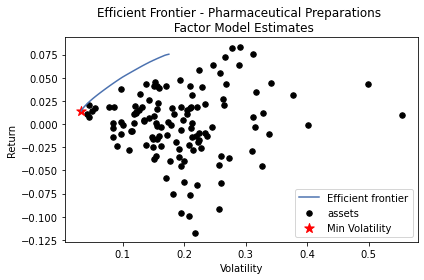

In [76]:
ef1 = EfficientFrontier(mu_Pharm, Factor_Model_cov, weight_bounds=(0, 0.2))

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef1, ax=ax, show_assets=True)

# Find and plot the tangency portfolio
ef2 = EfficientFrontier(mu_Pharm, Factor_Model_cov, weight_bounds=(0, 0.2))
# min volatility
ef2.min_volatility()
ret_tangent, std_tangent, _ = ef2.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Min Volatility")

# Format
ax.set_title("Efficient Frontier - Pharmaceutical Preparations \n Factor Model Estimates")
ax.legend()
plt.tight_layout()
plt.savefig('images/Efficient_Frontier_Returns_Pharmaceutical_Preparations.png', dpi=200, bbox_inches='tight')
plt.show()

##### Min Volatility Portfolio

###### Performance

In [77]:
ef2.portfolio_performance(verbose=True);

Expected annual return: 1.4%
Annual volatility: 3.3%
Sharpe Ratio: -0.18


###### Weights

In [78]:
companies = []
weights = []
for company, weight in ef2.clean_weights().items():
    if weight != 0:
        companies.append(company)
        weights.append(weight)
        
dic = {'Company_Name':companies,'Weight':weights}
min_vol = pd.DataFrame(dic)
min_vol.to_csv("data/min_vol_factor_model_Pharmaceutical_Preparations.csv", index = False)

In [79]:
pd.read_csv("data/min_vol_factor_model_Pharmaceutical_Preparations.csv")

,Company_Name,Weight
0,JOHNSON & JOHNSON,0.2000
1,LILLY ELI & CO,0.1825
2,PFIZER INC,0.2000
3,BIOSPECIFICS TECHNOLOGIES CORP,0.0175
4,ZOETIS INC.,0.2000
5,"MERCK & CO., INC.",0.2000


### Results for the Other 4 Industries

In [80]:
SIC_list = [7372, 1311, 6798, 6022]
SIC_desc = ['Prepackaged Software (mass reproduction of software)', 'Crude Petroleum and Natural Gas', 
           'Real Estate Investment Trusts', 'State Commercial Banks (commercial banking)']

#### Prepackaged Software (mass reproduction of software)

In [83]:
SIC = SIC_list[0]
    
industry_name = SIC_desc[SIC_list.index(SIC)]
    
# get the names of the companies in the other industries
Companies = df[df.SIC == SIC]
Company_list = Companies.index

# get the companies name that match return data and business description data
SET = (set(Company_list) & set(r_selected.index))
LIST = [*SET, ]

B_matrix = prob.T[LIST].T
B_matrix = B_matrix[~B_matrix.index.duplicated(keep="first")]

r = r_selected.T[LIST].T

tmp = cov[LIST].T
cov = tmp[LIST]

coef_mat = pd.DataFrame(0, index = r.columns, columns = range(n_components))
res_mat = pd.DataFrame(0, index = r.index, columns = r.columns)

from sklearn.linear_model import LinearRegression

for i in range(len(r.columns)):
    LR = LinearRegression()
    date = r.columns[i]
    r_t_i = r[date] 
    r_t_i_demean = r_t_i - r_t_i.mean()
    reg = LR.fit(B_matrix, r_t_i_demean)
    coef_mat.iloc[i] = reg.coef_
    prediction = B_matrix.dot(reg.coef_)
    residual_t_i = r_t_i_demean - prediction
    res_mat[date] = residual_t_i

mu_sample = mu[LIST]

cov_Factor_Model = pd.DataFrame(np.array(B_matrix.dot(coef_mat.cov()).dot(B_matrix.T)) + 
                                np.diag(np.diag(res_mat.T.cov()))).set_index(B_matrix.index)
cov_Factor_Model.columns = B_matrix.index

cor_Factor_Model = correlation_from_covariance(cov_Factor_Model)

tmp = cov[LIST].T
cov = tmp[LIST]

sd = pd.DataFrame(np.sqrt(np.diag(np.diagonal(cov))))
sd = sd.set_index(cov.index)
sd.columns = cov.index
Factor_Model_cov = pd.DataFrame((np.dot(np.dot(sd, cor_Factor_Model),sd)))

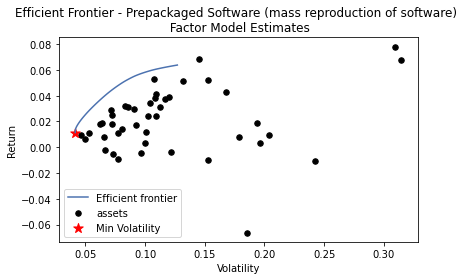

In [84]:
# perform minimum variance analysis
ef1 = EfficientFrontier(mu_sample, Factor_Model_cov, weight_bounds=(0, 0.2))

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef1, ax=ax, show_assets=True)

# Find and plot the tangency portfolio
ef2 = EfficientFrontier(mu_sample, Factor_Model_cov, weight_bounds=(0, 0.2))
# min volatility
ef2.min_volatility()
ret_tangent, std_tangent, _ = ef2.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Min Volatility")

# Format
ax.set_title("Efficient Frontier - %s \n Factor Model Estimates" %industry_name)
ax.legend()
plt.tight_layout()
#plt.savefig('images/Efficient_Frontier_Factor_Model_Estimates_Prepackaged_Software.png', dpi=200, bbox_inches='tight')
#plt.show()

![Efficient_Frontier_Factor_Model_Estimates_Prepackaged_Software.png](images/Efficient_Frontier_Factor_Model_Estimates_Prepackaged_Software.png)

##### Min Volatility Portfolio

###### Performance

In [85]:
ef2.portfolio_performance(verbose=True);

Expected annual return: 1.1%
Annual volatility: 4.1%
Sharpe Ratio: -0.21


###### Weights

In [86]:
companies = []
weights = []
for company, weight in ef2.clean_weights().items():
    if weight != 0:
        companies.append(company)
        weights.append(weight)
        
dic = {'Company_Name':companies,'Weight':weights}
min_vol = pd.DataFrame(dic)
min_vol.to_csv("data/min_vol_factor_model_Prepackaged_Software.csv", index = False)

In [87]:
pd.read_csv("data/min_vol_factor_model_Prepackaged_Software.csv")

,Company_Name,Weight
0,"POLARITYTE, INC.",0.01095
1,"BLACK KNIGHT, INC.",0.20000
2,MICROSTRATEGY INC,0.00228
3,AWARE INC /MA/,0.06064
4,"ACI WORLDWIDE, INC.",0.20000
5,REALPAGE INC,0.02255
6,ULTIMATE SOFTWARE GROUP INC,0.05857
7,"Q2 HOLDINGS, INC.",0.00038
8,ANSYS INC,0.03257
9,NATIONAL INSTRUMENTS CORP,0.11657


#### Crude Petroleum and Natural Gas
When we conduct the same analysis, there is no weight shown. Efficient frontier cannot be found.

In [96]:
SIC = SIC_list[1]
    
industry_name = SIC_desc[SIC_list.index(SIC)]
    
# get the names of the companies in the other industries
Companies = df[df.SIC == SIC]
Company_list = Companies.index

# get the companies name that match return data and business description data
SET = (set(Company_list) & set(r_selected.index))
LIST = [*SET, ]

mu_sample = mu[LIST]
# get the outliers
outlier = mu_sample[mu_sample>1].index
mu_sample = mu_sample.drop(outlier)
LIST = mu_sample.index

B_matrix = prob.T[LIST].T
B_matrix = B_matrix[~B_matrix.index.duplicated(keep="first")]

r = r_selected.T[LIST].T

coef_mat = pd.DataFrame(0, index = r.columns, columns = range(n_components))
res_mat = pd.DataFrame(0, index = r.index, columns = r.columns)

from sklearn.linear_model import LinearRegression

for i in range(len(r.columns)):
    LR = LinearRegression()
    date = r.columns[i]
    r_t_i = r[date] 
    r_t_i_demean = r_t_i - r_t_i.mean()
    reg = LR.fit(B_matrix, r_t_i_demean)
    coef_mat.iloc[i] = reg.coef_
    prediction = B_matrix.dot(reg.coef_)
    residual_t_i = r_t_i_demean - prediction
    res_mat[date] = residual_t_i

mu_sample = mu[LIST]

cov_Factor_Model = pd.DataFrame(np.array(B_matrix.dot(coef_mat.cov()).dot(B_matrix.T)) + 
                                np.diag(np.diag(res_mat.T.cov()))).set_index(B_matrix.index)
cov_Factor_Model.columns = B_matrix.index

cor_Factor_Model = correlation_from_covariance(cov_Factor_Model)

tmp = cov[LIST].T
cov_company = tmp[LIST]

sd = pd.DataFrame(np.sqrt(np.diag(np.diagonal(cov_company))))
sd = sd.set_index(cov_company.index)
sd.columns = cov_company.index
Factor_Model_cov = pd.DataFrame((np.dot(np.dot(sd, cor_Factor_Model),sd)))

ValueError: Weights is None

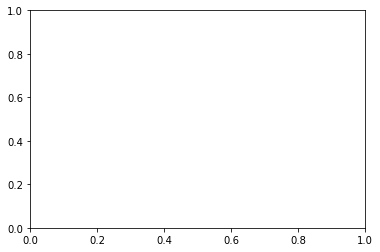

In [98]:
# perform minimum variance analysis
ef1 = EfficientFrontier(mu_sample, Factor_Model_cov, weight_bounds=(0, 0.2))

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef1, ax=ax, show_assets=True)

# Find and plot the tangency portfolio
ef2 = EfficientFrontier(mu_sample, Factor_Model_cov, weight_bounds=(0, 0.2))
# min volatility
ef2.min_volatility()
ret_tangent, std_tangent, _ = ef2.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Min Volatility")

# Format
ax.set_title("Efficient Frontier - %s \n Factor Model Estimates" %industry_name)
ax.legend()
plt.tight_layout()
#plt.savefig('images/Efficient_Frontier_Factor_Model_Estimates_Crude_Petroleum_and_Natural_Gas.png', dpi=200, bbox_inches='tight')
#plt.show()

![Efficient_Frontier_Factor_Model_Estimates_Crude_Petroleum_and_Natural_Gas.png](images/Efficient_Frontier_Factor_Model_Estimates_Crude_Petroleum_and_Natural_Gas.png)

##### Min Volatility Portfolio

###### Performance

In [36]:
ef2.portfolio_performance(verbose=True);

Expected annual return: 0.7%
Annual volatility: 32.4%
Sharpe Ratio: -0.04


###### Weights

In [37]:
companies = []
weights = []
for company, weight in ef2.clean_weights().items():
    if weight != 0:
        companies.append(company)
        weights.append(weight)
        
dic = {'Company_Name':companies,'Weight':weights}
min_vol = pd.DataFrame(dic)
min_vol.to_csv("data/min_vol_factor_model_Crude_Petroleum_and_Natural_Gas.csv", index = False)

In [38]:
pd.read_csv("data/min_vol_factor_model_Crude_Petroleum_and_Natural_Gas.csv")

,Company_Name,Weight
0,CONTANGO OIL & GAS CO,0.04169
1,PANHANDLE OIL & GAS INC,0.05922
2,"DORCHESTER MINERALS, L.P.",0.02716
3,SANCHEZ ENERGY CORP,0.00736
4,KOSMOS ENERGY LTD.,0.14627
5,SM ENERGY CO,0.07055
6,SRC ENERGY INC.,0.00429
7,GULFPORT ENERGY CORP,0.00625
8,CALLON PETROLEUM CO,0.07632
9,CONCHO RESOURCES INC,0.03770


#### Real Estate Investment Trusts

In [94]:
SIC = SIC_list[2]
    
industry_name = SIC_desc[SIC_list.index(SIC)]
    
# get the names of the companies in the other industries
Companies = df[df.SIC == SIC]
Company_list = Companies.index

# get the companies name that match return data and business description data
SET = (set(Company_list) & set(r_selected.index))
LIST = [*SET, ]

mu_sample = mu[LIST]
# get the outliers
outlier = mu_sample[mu_sample>1].index
mu_sample = mu_sample.drop(outlier)
LIST = mu_sample.index

B_matrix = prob.T[LIST].T
B_matrix = B_matrix[~B_matrix.index.duplicated(keep="first")]

r = r_selected.T[LIST].T

coef_mat = pd.DataFrame(0, index = r.columns, columns = range(n_components))
res_mat = pd.DataFrame(0, index = r.index, columns = r.columns)

from sklearn.linear_model import LinearRegression

for i in range(len(r.columns)):
    LR = LinearRegression()
    date = r.columns[i]
    r_t_i = r[date] 
    r_t_i_demean = r_t_i - r_t_i.mean()
    reg = LR.fit(B_matrix, r_t_i_demean)
    coef_mat.iloc[i] = reg.coef_
    prediction = B_matrix.dot(reg.coef_)
    residual_t_i = r_t_i_demean - prediction
    res_mat[date] = residual_t_i

mu_sample = mu[LIST]

cov_Factor_Model = pd.DataFrame(np.array(B_matrix.dot(coef_mat.cov()).dot(B_matrix.T)) + 
                                np.diag(np.diag(res_mat.T.cov()))).set_index(B_matrix.index)
cov_Factor_Model.columns = B_matrix.index

cor_Factor_Model = correlation_from_covariance(cov_Factor_Model)

tmp = cov[LIST].T
cov_company = tmp[LIST]

sd = pd.DataFrame(np.sqrt(np.diag(np.diagonal(cov_company))))
sd = sd.set_index(cov_company.index)
sd.columns = cov_company.index
Factor_Model_cov = pd.DataFrame((np.dot(np.dot(sd, cor_Factor_Model),sd)))

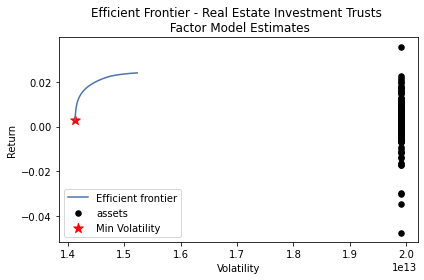

In [95]:
# perform minimum variance analysis
ef1 = EfficientFrontier(mu_sample, cov_Factor_Model, weight_bounds=(0, 0.2))

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef1, ax=ax, show_assets=True)

# Find and plot the tangency portfolio
ef2 = EfficientFrontier(mu_sample, cov_Factor_Model, weight_bounds=(0, 0.2))
# min volatility
ef2.min_volatility()
ret_tangent, std_tangent, _ = ef2.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Min Volatility")

# Format
ax.set_title("Efficient Frontier - %s \n Factor Model Estimates" %industry_name)
ax.legend()
plt.tight_layout()
#plt.savefig('images/Efficient_Frontier_Factor_Model_Estimates_Real_Estate_Investment_Trusts.png', dpi=200, bbox_inches='tight')
plt.show()

![Efficient_Frontier_Factor_Model_Estimates_Real_Estate_Investment_Trusts.png](images/Efficient_Frontier_Factor_Model_Estimates_Real_Estate_Investment_Trusts.png)

##### Min Volatility Portfolio

###### Performance

In [41]:
ef2.portfolio_performance(verbose=True);

Expected annual return: 0.3%
Annual volatility: 1413398082205339.2%
Sharpe Ratio: -0.00


###### Weights

In [42]:
companies = []
weights = []
for company, weight in ef2.clean_weights().items():
    if weight != 0:
        companies.append(company)
        weights.append(weight)
        
dic = {'Company_Name':companies,'Weight':weights}
min_vol = pd.DataFrame(dic)
min_vol.to_csv("data/min_vol_factor_model_Real_Estate_Investment_Trusts.csv", index = False)

In [43]:
pd.read_csv("data/min_vol_factor_model_Real_Estate_Investment_Trusts.csv")

,Company_Name,Weight
0,PENNSYLVANIA REAL ESTATE INVESTMENT TRUST,0.00781
1,ISTAR INC.,0.00781
2,"NEXPOINT RESIDENTIAL TRUST, INC.",0.00781
3,"RYMAN HOSPITALITY PROPERTIES, INC.",0.00781
4,LEXINGTON REALTY TRUST,0.00781
...,...,...
123,HOWARD HUGHES CORP,0.00781
124,APARTMENT INVESTMENT & MANAGEMENT CO,0.00781
125,LAMAR ADVERTISING CO/NEW,0.00781
126,"ARMOUR RESIDENTIAL REIT, INC.",0.00781


#### State Commercial Banks (commercial banking)

In [44]:
SIC = SIC_list[3]
    
industry_name = SIC_desc[SIC_list.index(SIC)]
    
# get the names of the companies in the other industries
Companies = df[df.SIC == SIC]
Company_list = Companies.index

# get the companies name that match return data and business description data
SET = (set(Company_list) & set(r_selected.index))
LIST = [*SET, ]

B_matrix = prob.T[LIST].T
B_matrix = B_matrix[~B_matrix.index.duplicated(keep="first")]

r = r_selected.T[LIST].T

coef_mat = pd.DataFrame(0, index = r.columns, columns = range(n_components))
res_mat = pd.DataFrame(0, index = r.index, columns = r.columns)

from sklearn.linear_model import LinearRegression

for i in range(len(r.columns)):
    LR = LinearRegression()
    date = r.columns[i]
    r_t_i = r[date] 
    r_t_i_demean = r_t_i - r_t_i.mean()
    reg = LR.fit(B_matrix, r_t_i_demean)
    coef_mat.iloc[i] = reg.coef_
    prediction = B_matrix.dot(reg.coef_)
    residual_t_i = r_t_i_demean - prediction
    res_mat[date] = residual_t_i

mu_sample = mu[LIST]

cov_Factor_Model = pd.DataFrame(np.array(B_matrix.dot(coef_mat.cov()).dot(B_matrix.T)) + 
                                np.diag(np.diag(res_mat.T.cov()))).set_index(B_matrix.index)
cov_Factor_Model.columns = B_matrix.index

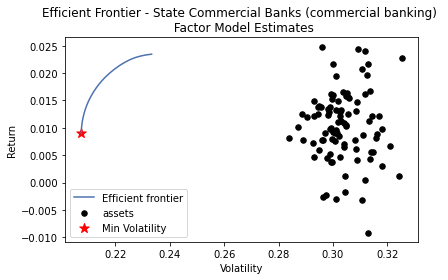

In [45]:
# perform minimum variance analysis
ef1 = EfficientFrontier(mu_sample, cov_Factor_Model, weight_bounds=(0, 0.2))


fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef1, ax=ax, show_assets=True)

# Find and plot the tangency portfolio
ef2 = EfficientFrontier(mu_sample, cov_Factor_Model, weight_bounds=(0, 0.2))
# min volatility
ef2.min_volatility()
ret_tangent, std_tangent, _ = ef2.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Min Volatility")

# Format
ax.set_title("Efficient Frontier - %s \n Factor Model Estimates" %industry_name)
ax.legend()
plt.tight_layout()
#plt.savefig('images/Efficient_Frontier_Factor_Model_Estimates_State_Commercial_Banks.png', dpi=200, bbox_inches='tight')
plt.show()

![Efficient_Frontier_Factor_Model_Estimates_State_Commercial_Banks.png](images/Efficient_Frontier_Factor_Model_Estimates_State_Commercial_Banks.png)

##### Min Volatility Portfolio

###### Performance

In [46]:
ef2.portfolio_performance(verbose=True);

Expected annual return: 0.9%
Annual volatility: 20.8%
Sharpe Ratio: -0.05


###### Weights

In [47]:
companies = []
weights = []
for company, weight in ef2.clean_weights().items():
    if weight != 0:
        companies.append(company)
        weights.append(weight)
        
dic = {'Company_Name':companies,'Weight':weights}
min_vol = pd.DataFrame(dic)
min_vol.to_csv("data/min_vol_factor_model_State_Commercial_Banks.csv", index = False)

In [48]:
pd.read_csv("data/min_vol_factor_model_State_Commercial_Banks.csv")

,Company_Name,Weight
0,WESTERN ALLIANCE BANCORPORATION,0.01266
1,"CAROLINA TRUST BANCSHARES, INC.",0.05794
2,BANK OF NEW YORK MELLON CORP,0.01833
3,UNITED BANKSHARES INC/WV,0.04209
4,"EAGLE BANCORP MONTANA, INC.",0.01243
5,"RELIANT BANCORP, INC.",0.00788
6,"GERMAN AMERICAN BANCORP, INC.",0.02933
7,OLD LINE BANCSHARES INC,0.00366
8,CAROLINA FINANCIAL CORP,0.00851
9,BANK OF THE JAMES FINANCIAL GROUP INC,0.02588
